In [269]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import folium
import warnings
import missingno as msno
from haversine import haversine, Unit

In [270]:
train_df = pd.read_csv('./datasets/train.csv')
test_df = pd.read_csv('./datasets/test.csv')
weather_df = pd.read_csv('./datasets/weather.csv')
spray_df = pd.read_csv('./datasets/spray.csv')

In [271]:
train_df.shape

(10506, 12)

In [272]:
train_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [273]:
train_df.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [274]:
# calculate number of duplicates in train df
duplicates = train_df[train_df['NumMosquitos'] < 50].duplicated(subset=None, keep='first')
print(f"There are {duplicates.sum()} duplicate rows with NumMosquitos < 50.")

There are 106 duplicate rows with NumMosquitos < 50.


In [275]:
# drop duplicate rows
duplicate_indices = train_df[train_df['NumMosquitos'] < 50].index[duplicates]
train_df = train_df.drop(index=duplicate_indices)

In [276]:
train_df.shape

(10400, 12)

In [277]:
train_df.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object

In [278]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df.set_index('Date', inplace=True)

In [279]:
train_df.head()

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


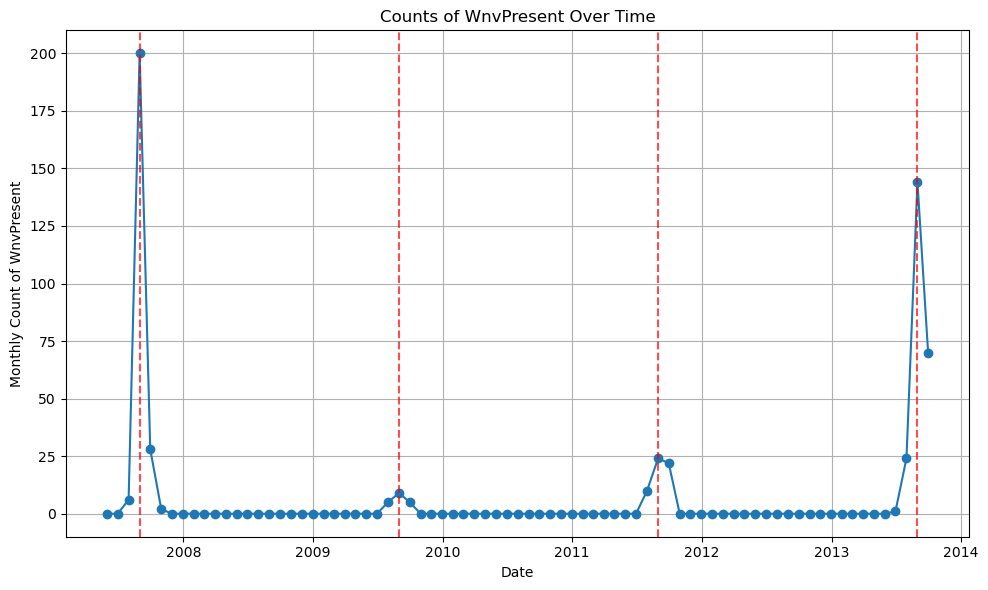

In [280]:
monthly_data = train_df['WnvPresent'].resample('M').sum()

# Plotting
plt.figure(figsize=(10,6))
plt.plot(monthly_data, marker='o', linestyle='-')
plt.title('Counts of WnvPresent Over Time')
plt.xlabel('Date')
plt.ylabel('Monthly Count of WnvPresent')

for date in monthly_data.index:
    if date.month == 8 and date.year % 2 != 0:
        plt.axvline(x=date, color='r', linestyle='--', alpha=0.7)

plt.grid(True)
plt.tight_layout()
plt.show()

In [281]:
weather_df.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [282]:
weather_df.shape

(2944, 22)

In [283]:
weather_df.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [284]:
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df.set_index('Date', inplace=True)

In [285]:
weather_df.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67,14,51,56,0,2,0448,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68,M,51,57,0,3,-,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51,-3,42,47,14,0,0447,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
2007-05-02,2,60,43,52,M,42,47,13,0,-,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
2007-05-03,1,66,46,56,2,40,48,9,0,0446,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [286]:
# Obtained from Kaggle website
station_1 = (41.995, -87.933)  # CHICAGO O'HARE INTERNATIONAL AIRPORT
station_2 = (41.786, -87.752)  # CHICAGO MIDWAY INTL ARPT

# Create a function to determine the closest station
def closest_station(lat, lon):
    coord = (lat, lon)
    if haversine(coord, station_1) < haversine(coord, station_2):
        return 1
    else:
        return 2

# Apply function to determine nearest weather station
train_df['Station'] = train_df.apply(lambda row: closest_station(row['Latitude'], row['Longitude']), axis=1)

In [287]:
spray_df['Date'] = pd.to_datetime(spray_df['Date'])
spray_df.set_index('Date', inplace=True)

In [288]:
spray_df.head()

,Time,Latitude,Longitude
Date,,,
2011-08-29,6:56:58 PM,42.391623,-88.089163
2011-08-29,6:57:08 PM,42.391348,-88.089163
2011-08-29,6:57:18 PM,42.391022,-88.089157
2011-08-29,6:57:28 PM,42.390637,-88.089158
2011-08-29,6:57:38 PM,42.390410,-88.088858


In [289]:
train_df.isnull().sum()

Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
Station                   0
dtype: int64

In [290]:
# Step 1: Split the strings
split_codes = weather_df['CodeSum'].str.split()

# Step 2: Flatten the list
all_codes = [code for sublist in split_codes for code in sublist]

# Step 3: Get unique codes
weather_codes = set(all_codes)

In [291]:
for code in weather_codes:
    weather_df[code] = weather_df['CodeSum'].apply(lambda x: 1 if code in x else 0)

In [292]:
weather_df.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,HZ,VCFG,GR,SQ,FG,BR,VCTS,DZ,SN,FG+
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67,14,51,56,0,2,0448,...,0,0,0,0,0,0,0,0,0,0
2007-05-01,2,84,52,68,M,51,57,0,3,-,...,0,0,0,0,0,0,0,0,0,0
2007-05-02,1,59,42,51,-3,42,47,14,0,0447,...,0,0,0,0,0,1,0,0,0,0
2007-05-02,2,60,43,52,M,42,47,13,0,-,...,1,0,0,0,0,1,0,0,0,0
2007-05-03,1,66,46,56,2,40,48,9,0,0446,...,0,0,0,0,0,0,0,0,0,0


In [293]:
weather_df.dtypes

Station          int64
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
MIFG             int64
TS               int64
TSRA             int64
FU               int64
RA               int64
BCFG             int64
HZ               int64
VCFG             int64
GR               int64
SQ               int64
FG               int64
BR               int64
VCTS             int64
DZ               int64
SN               int64
FG+              int64
dtype: object

In [294]:
weather_df['WetBulb'].value_counts()

WetBulb
63    135
65    131
59    129
61    123
64    121
62    118
67    117
66    113
60    111
69    107
57    105
70    102
55     99
71     99
68     98
56     95
58     95
52     78
46     72
72     71
53     69
47     61
51     57
54     56
73     56
50     55
45     53
48     51
49     50
74     50
44     45
42     35
40     31
43     31
75     20
41     19
38     17
39     15
36      9
77      8
76      8
35      8
34      5
33      5
37      5
M       4
32      1
78      1
Name: count, dtype: int64

In [295]:
# M stands for missing data
weather_df['WetBulb'].replace('M', np.nan, inplace=True)

# Dropping the rows since there are only 4
weather_df = weather_df.dropna(subset=['WetBulb'])
weather_df['WetBulb'] = weather_df['WetBulb'].astype(float).astype(int);

In [296]:
weather_df['Heat'].value_counts()

Heat
0     1866
4       88
1       86
2       81
8       67
3       66
5       61
15      57
12      49
7       49
10      48
11      48
9       46
13      46
6       45
14      36
16      29
20      28
19      24
18      24
21      19
17      17
23      15
22      12
M       11
24       7
25       5
26       4
27       2
28       2
29       2
Name: count, dtype: int64

In [297]:
# M stands for missing data
weather_df['Heat'].replace('M', np.nan, inplace=True)

# Dropping the rows since there are only 11
weather_df = weather_df.dropna(subset=['Heat'])
weather_df['Heat'] = weather_df['Heat'].astype(float).astype(int);

In [298]:
weather_df['Cool'].value_counts()

Cool
 0    1147
 8     137
 5     117
12     116
10     110
 6     108
 9     107
 7     104
 4     103
13     101
11     100
 3      99
14      98
 1      93
 2      89
15      84
16      55
17      48
18      34
19      21
20      16
21      16
22       9
24       4
23       4
26       4
25       2
27       1
28       1
29       1
Name: count, dtype: int64

In [299]:
weather_df['Cool'] = weather_df['Cool'].astype(float).astype(int);

In [300]:
weather_df['Tavg'] = weather_df['Tavg'].astype(float).astype(int);

In [309]:
weather_df.dtypes

Station          int64
Tmax             int64
Tmin             int64
Tavg             int64
Depart          object
DewPoint         int64
WetBulb          int64
Heat             int64
Cool             int64
Sunrise          int64
Sunset           int64
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
MIFG             int64
TS               int64
TSRA             int64
FU               int64
RA               int64
BCFG             int64
HZ               int64
VCFG             int64
GR               int64
SQ               int64
FG               int64
BR               int64
VCTS             int64
DZ               int64
SN               int64
FG+              int64
dtype: object

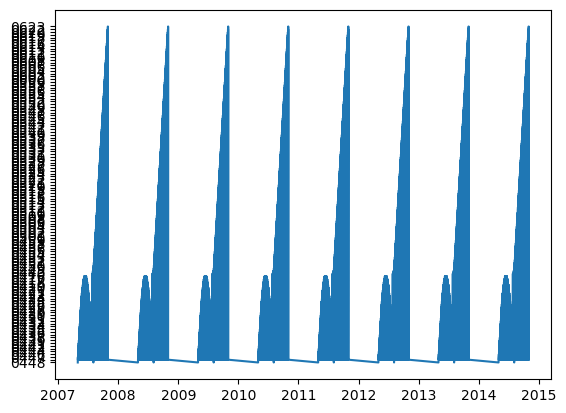

In [302]:
plt.plot(weather_df['Sunrise']);

In [303]:
# Use forward fill for Sunrise
weather_df['Sunrise'] = pd.to_numeric(weather_df['Sunrise'], errors='coerce')
weather_df['Sunrise'] = weather_df['Sunrise'].fillna(method='ffill')
weather_df['Sunrise'] = weather_df['Sunrise'].astype(float).astype(int);

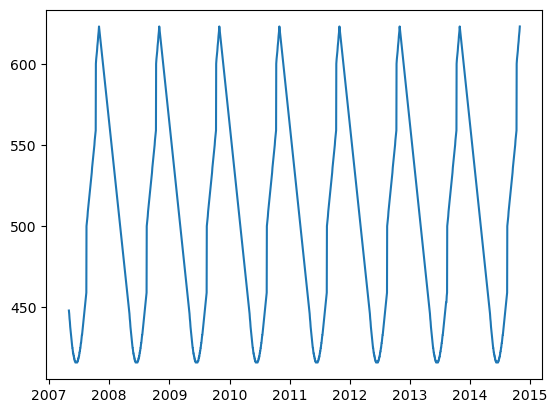

In [304]:
plt.plot(weather_df['Sunrise']);

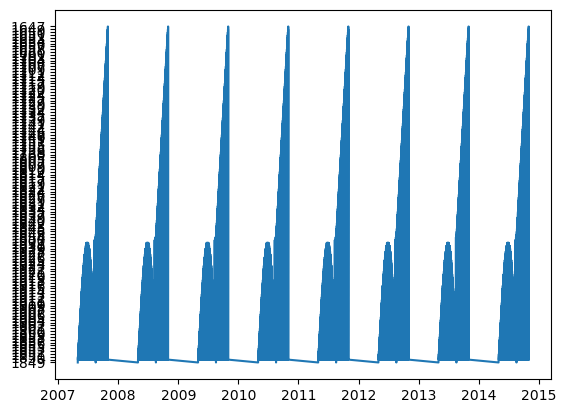

In [305]:
plt.plot(weather_df['Sunset']);

In [306]:
# Use forward fill for Sunset
weather_df['Sunset'] = pd.to_numeric(weather_df['Sunset'], errors='coerce')
weather_df['Sunset'] = weather_df['Sunset'].fillna(method='ffill')
weather_df['Sunset'] = weather_df['Sunset'].astype(float).astype(int);

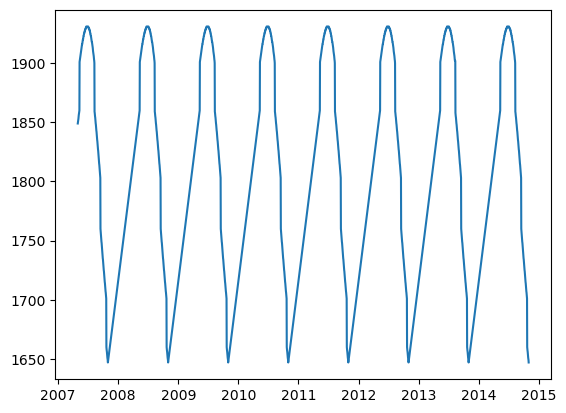

In [307]:
plt.plot(weather_df['Sunset']);

In [317]:
len(weather_df[weather_df['Depth']=='M']['Depth'])/weather_df.shape[0] * 100
# drop Depth column since about 50% is missing

49.8463639467395

In [318]:
len(weather_df[weather_df['Water1']=='M']['Water1'])/weather_df.shape[0] * 100
# drop Water1 since all values are missing

100.0

In [320]:
len(weather_df[weather_df['SnowFall']=='M']['SnowFall'])/weather_df.shape[0] * 100
# drop SnowFall column since about 50% is missing

49.8463639467395

In [341]:
weather_df['CodeSum'].isnull().sum()

0